In [ ]:
# 📦 Install required packages (if not already available)
!pip install librosa tensorflow matplotlib seaborn scikit-learn numpy pandas

In [ ]:
!pip install kagglehub tensorflow matplotlib seaborn scikit-learn pandas numpy


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, Dropout, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
# Download the preprocessed GTZAN dataset
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
csv_path = os.path.join(path, "Data", "features_3_sec.csv")


100%|██████████| 1.21G/1.21G [00:15<00:00, 82.1MB/s]

Extracting files...


In [ ]:
df = pd.read_csv(csv_path)
print("✅ Dataset loaded:", df.shape)
df.head()

✅ Dataset loaded: (9990, 60)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# Drop filename column
if 'filename' in df.columns:
    df = df.drop(columns=['filename'])

# Separate features and labels
X = df.drop(columns=['label'])
y = df['label']

# 🔹 Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 Label Encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# 🔹 Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_cat,
    test_size=0.2,
    random_state=42,
    stratify=y_cat  # ensures balanced genre distribution
)

# 🔹 Reshape for TCN (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("✅ Training shape:", X_train.shape)
print("✅ Testing shape:", X_test.shape)


✅ Training shape: (7992, 58, 1)
✅ Testing shape: (1998, 58, 1)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, Dropout, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam

def residual_block(x, filters, kernel_size, dilation_rate, dropout_rate=0.3):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def build_tcn(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = residual_block(inputs, 64, 3, 1)
    x = residual_block(x, 128, 3, 2)
    x = residual_block(x, 256, 3, 4)
    x = residual_block(x, 256, 3, 8)
    x = Dropout(0.4)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

model = build_tcn((X_train.shape[1], 1), num_classes=y_train.shape[1])
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 58, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 58, 64)    │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 58, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 58, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 58, 64)    │          0 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 58, 64)    │     12,352 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 58, 64)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 58, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 58, 64)    │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 58, 128)   │     24,704 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 128)   │        512 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 58, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 58, 128)   │          0 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 58, 128)   │     49,280 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 128)   │        512 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 58, 128)   │      8,320 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 58, 128)   │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 58, 128)   │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 58, 256)   │     98,560 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 256)   │      1,024 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 857,034 (3.27 MB)

 Trainable params: 854,218 (3.26 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 116ms/step - accuracy: 0.2819 - loss: 1.9464 - val_accuracy: 0.1221 - val_loss: 2.6038
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4796 - loss: 1.4641 - val_accuracy: 0.1962 - val_loss: 2.7335
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5344 - loss: 1.3063 - val_accuracy: 0.3879 - val_loss: 1.7953
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5786 - loss: 1.2092 - val_accuracy: 0.5931 - val_loss: 1.1899
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6004 - loss: 1.1331 - val_accuracy: 0.6361 - val_loss: 1.0181
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6508 - loss: 1.0123 - val_accuracy: 0.6727 - val_loss: 0.9426
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6766 - loss: 0.9384 - val_accuracy: 0.7092 - val_loss: 0.8678
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6998 - loss: 0.8700 - val_ac

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8782 - loss: 0.4264
🎯 Improved Test Accuracy: 88.34%


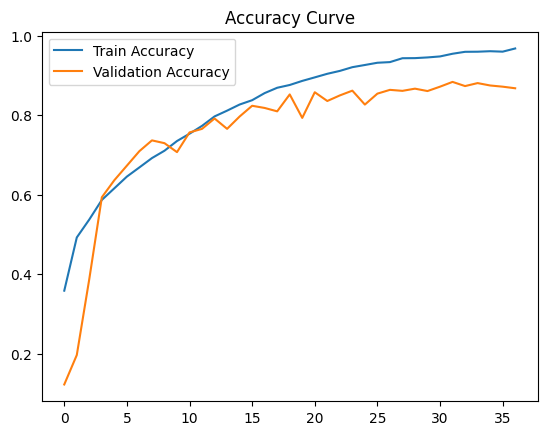

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"🎯 Improved Test Accuracy: {acc*100:.2f}%")

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8782 - loss: 0.4264
🎯 Test Accuracy: 88.34%
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step

Classification Report:

              precision    recall  f1-score   support

       blues       0.86      0.93      0.89       200
   classical       0.95      0.94      0.95       200
     country       0.75      0.87      0.81       199
       disco       0.90      0.89      0.89       200
      hiphop       0.92      0.88      0.90       200
        jazz       0.90      0.88      0.89       200
       metal       0.98      0.90      0.94       200
         pop       0.91      0.87      0.89       200
      reggae       0.93      0.81      0.87       200
        rock       0.78      0.86      0.82       199

    accuracy                           0.88      1998
   macro avg       0.89      0.88      0.88      1998
weighted avg       0.89      0.88      0.88      1998



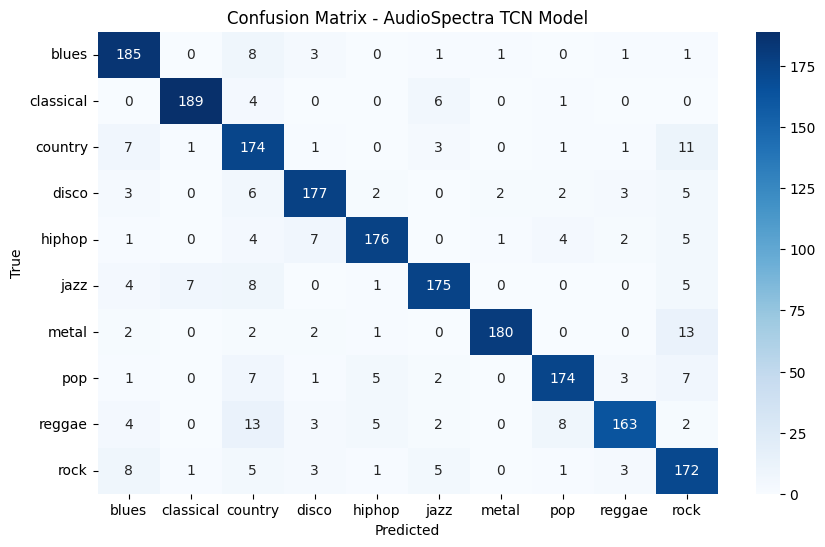

In [ ]:
# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"🎯 Test Accuracy: {acc*100:.2f}%")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - AudioSpectra TCN Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


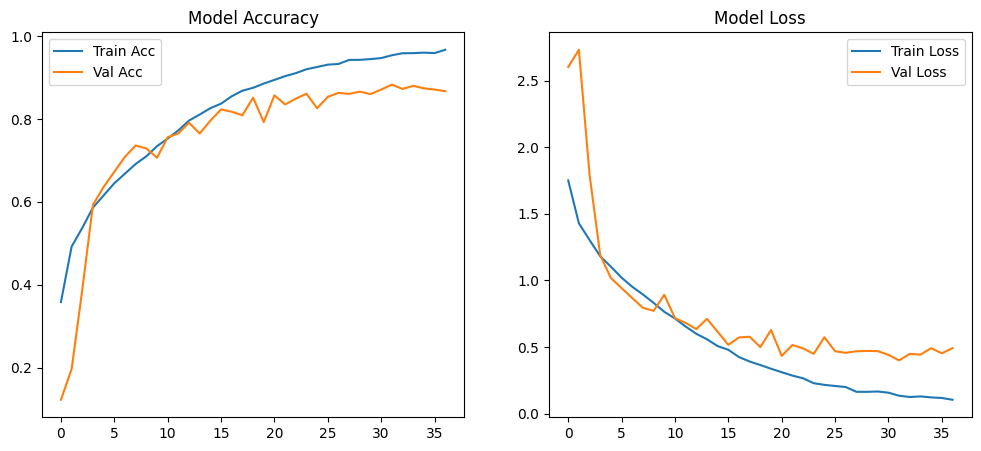

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


In [ ]:
!pip install yt_dlp pydub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 77.4 MB/s eta 0:00:00


In [ ]:
import yt_dlp
from pydub import AudioSegment
import os

# 🔹 Your YouTube link
youtube_url = "https://youtu.be/ix1sJ6cbkxM?si=5xFbQ12p_akw7VKY"

# 🔹 Download best-quality audio
ydl_opts = {
    'format': 'bestaudio/best',
    'outtmpl': 'youtube_download.%(ext)s',
    'quiet': False,
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([youtube_url])

# 🔹 Locate the downloaded file
input_file = None
for f in os.listdir():
    if f.startswith("youtube_download"):
        input_file = f
        break

# 🔹 Convert to mono 22 kHz WAV (shorten to 30 s to keep it small)
if input_file:
    song = AudioSegment.from_file(input_file)
    song = song.set_frame_rate(22050).set_channels(1)
    song = song[:30 * 1000]   # first 30 seconds
    song.export("youtube_song.wav", format="wav")
    print("✅ Saved as youtube_song.wav")
else:
    print("❌ Audio file not found.")


/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


[youtube] Extracting URL: https://youtu.be/ix1sJ6cbkxM?si=5xFbQ12p_akw7VKY
[youtube] ix1sJ6cbkxM: Downloading webpage
[youtube] ix1sJ6cbkxM: Downloading android sdkless player API JSON
[youtube] ix1sJ6cbkxM: Downloading tv client config
[youtube] ix1sJ6cbkxM: Downloading player c6d7bdc9-main
[youtube] ix1sJ6cbkxM: Downloading tv player API JSON
[youtube] ix1sJ6cbkxM: Downloading web safari player API JSON


[youtube] ix1sJ6cbkxM: Downloading m3u8 information
[info] ix1sJ6cbkxM: Downloading 1 format(s): 251
[download] Sleeping 5.00 seconds as required by the site...
[download] Destination: youtube_download.webm
[download] 100% of    2.90MiB in 00:00:00 at 8.51MiB/s   
✅ Saved as youtube_song.wav


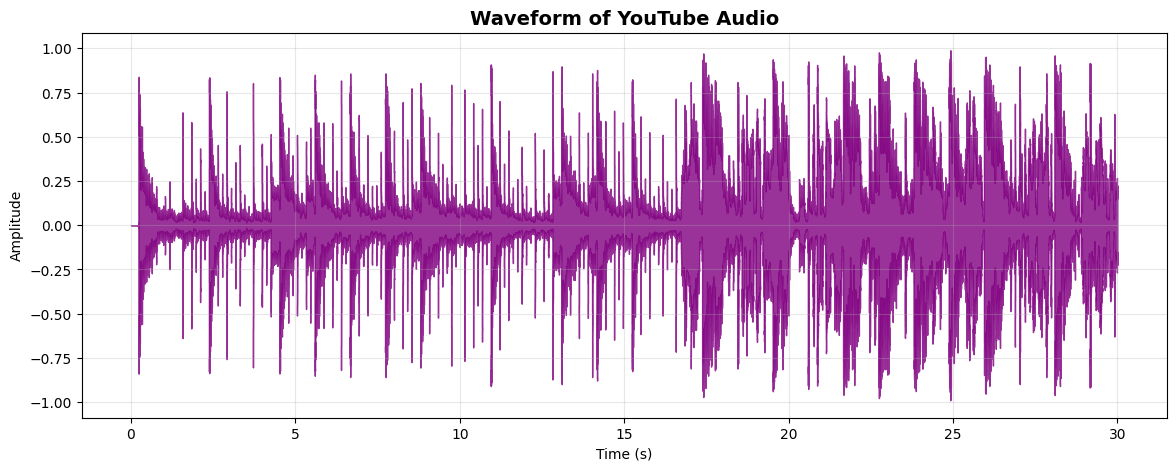

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipython-input-4113950017.py:39: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  'tempo': librosa.beat.tempo(y=y, sr=sr)[0],


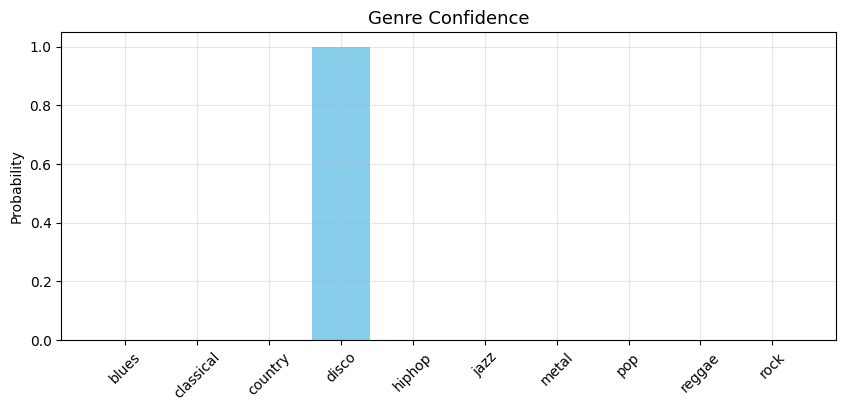

🎵 Predicted Genre: disco

✅ The predicted genre for your YouTube song is: **disco**


In [ ]:
import librosa, librosa.display, matplotlib.pyplot as plt, numpy as np
import pandas as pd

audio_file_path = "youtube_song.wav"

# Waveform
audio_data, sr = librosa.load(audio_file_path, sr=None)
plt.figure(figsize=(14,5))
librosa.display.waveshow(audio_data, sr=sr, color='purple', alpha=0.8)
plt.title("Waveform of YouTube Audio", fontsize=14, fontweight='bold')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(alpha=0.3)
plt.show()

# --- Prediction helper ---
def predict_genre_tcn(audio_path, model, scaler, label_encoder):
    y, sr = librosa.load(audio_path, sr=22050)

    # Extract all features used during training, including 'length'
    features = {
        'length': len(y),
        'chroma_stft_mean': np.mean(librosa.feature.chroma_stft(y=y, sr=sr)),
        'chroma_stft_var': np.var(librosa.feature.chroma_stft(y=y, sr=sr)),
        'rms_mean': np.mean(librosa.feature.rms(y=y)),
        'rms_var': np.var(librosa.feature.rms(y=y)),
        'spectral_centroid_mean': np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
        'spectral_centroid_var': np.var(librosa.feature.spectral_centroid(y=y, sr=sr)),
        'spectral_bandwidth_mean': np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
        'spectral_bandwidth_var': np.var(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
        'rolloff_mean': np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)),
        'rolloff_var': np.var(librosa.feature.spectral_rolloff(y=y, sr=sr)),
        'zero_crossing_rate_mean': np.mean(librosa.feature.zero_crossing_rate(y=y)),
        'zero_crossing_rate_var': np.var(librosa.feature.zero_crossing_rate(y=y)),
        'harmony_mean': np.mean(librosa.effects.harmonic(y=y)),
        'harmony_var': np.var(librosa.effects.harmonic(y=y)),
        'perceptr_mean': np.mean(librosa.effects.percussive(y=y)),
        'perceptr_var': np.var(librosa.effects.percussive(y=y)),
        'tempo': librosa.beat.tempo(y=y, sr=sr)[0],
    }

    # Extract MFCCs (20 coefficients as in the original dataset)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    for i in range(20):
        features[f'mfcc{i+1}_mean'] = np.mean(mfccs[i])
        features[f'mfcc{i+1}_var'] = np.var(mfccs[i])

    # Convert to DataFrame
    features_df = pd.DataFrame([features])
    # Ensure the order of columns matches the training data
    features_df = features_df[X.columns]
    features_scaled = scaler.transform(features_df)
    features_scaled = features_scaled.reshape(features_scaled.shape[0], features_scaled.shape[1], 1)


    pred = model.predict(features_scaled)
    pred_class = np.argmax(pred)
    predicted_genre = label_encoder.classes_[pred_class]

    plt.figure(figsize=(10,4))
    plt.bar(label_encoder.classes_, pred[0], color='skyblue')
    plt.xticks(rotation=45)
    plt.title("Genre Confidence", fontsize=13)
    plt.ylabel("Probability")
    plt.grid(alpha=0.3)
    plt.show()

    print(f"🎵 Predicted Genre: {predicted_genre}")
    return predicted_genre

# Run prediction
predicted_genre = predict_genre_tcn(audio_file_path, model, scaler, le)
print(f"\n✅ The predicted genre for your YouTube song is: **{predicted_genre}**")

In [ ]:
import yt_dlp
from pydub import AudioSegment
import os

# 🔹 Your YouTube link
youtube_url = "https://youtu.be/Qwo9ML6HC5E?si=a_5MntGQqZ_CityW"

# 🔹 Download best-quality audio
ydl_opts = {
    'format': 'bestaudio/best',
    'outtmpl': 'youtube_audio.%(ext)s',
    'quiet': False,
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([youtube_url])

# 🔹 Locate downloaded file
input_file = None
for f in os.listdir():
    if f.startswith("youtube_audio"):
        input_file = f
        break

# 🔹 Convert to mono .wav (30 sec for simplicity)
if input_file:
    song = AudioSegment.from_file(input_file)
    song = song.set_frame_rate(22050).set_channels(1)
    song = song[:30 * 1000]  # Take first 30 seconds
    song.export("youtube_song.wav", format="wav")
    print("✅ Saved as youtube_song.wav")
else:
    print("❌ Error: Could not find downloaded audio file.")


[youtube] Extracting URL: https://youtu.be/Qwo9ML6HC5E?si=a_5MntGQqZ_CityW
[youtube] Qwo9ML6HC5E: Downloading webpage
[youtube] Qwo9ML6HC5E: Downloading android sdkless player API JSON
[youtube] Qwo9ML6HC5E: Downloading tv client config
[youtube] Qwo9ML6HC5E: Downloading tv player API JSON
[youtube] Qwo9ML6HC5E: Downloading web safari player API JSON
[youtube] Qwo9ML6HC5E: Downloading player c6d7bdc9-main


         player = https://www.youtube.com/s/player/c6d7bdc9/player_ias.vflset/en_US/base.js
         Please report this issue on  https://github.com/yt-dlp/yt-dlp/issues?q= , filling out the appropriate issue template. Confirm you are on the latest version using  yt-dlp -U


[youtube] Qwo9ML6HC5E: Downloading m3u8 information
[info] Qwo9ML6HC5E: Downloading 1 format(s): 251
[download] Sleeping 4.00 seconds as required by the site...
[download] Destination: youtube_audio.webm
[download] 100% of    3.37MiB in 00:00:00 at 9.75MiB/s   
✅ Saved as youtube_song.wav


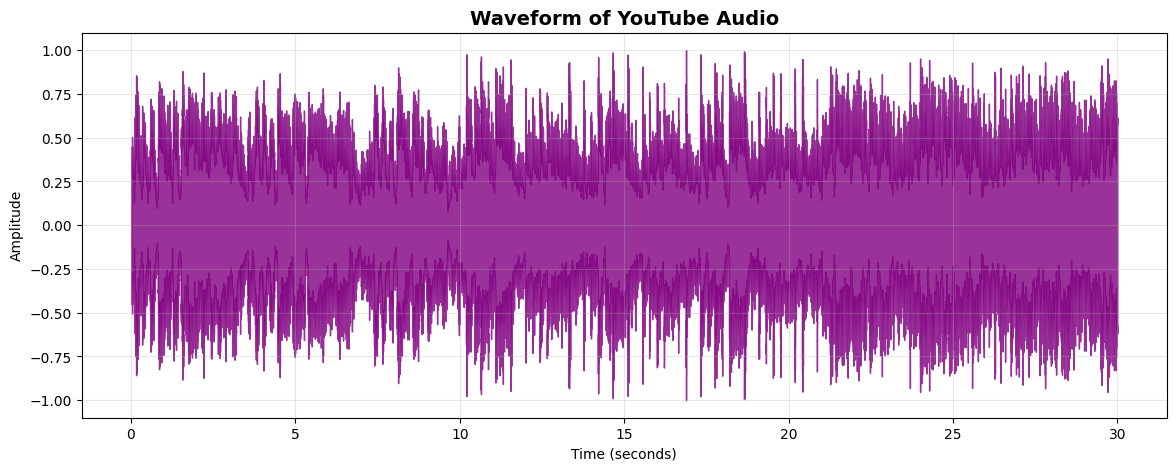

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/tmp/ipython-input-1586987305.py:39: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  'tempo': librosa.beat.tempo(y=y, sr=sr)[0],


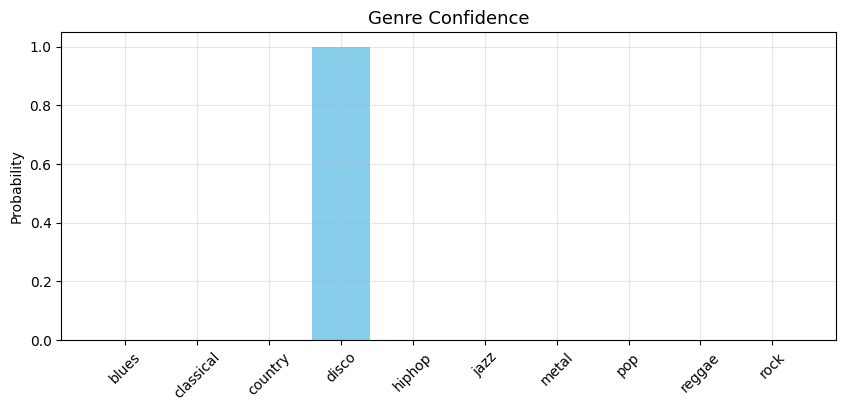

🎵 Predicted Genre: disco (100.00% confidence)

✅ Predicted genre for YouTube song: **disco**


In [ ]:
import librosa, librosa.display, matplotlib.pyplot as plt, numpy as np
import pandas as pd

audio_file_path = "youtube_song.wav"

# Visualize waveform
audio_data, sr = librosa.load(audio_file_path, sr=None)
plt.figure(figsize=(14,5))
librosa.display.waveshow(audio_data, sr=sr, color='purple', alpha=0.8)
plt.title("Waveform of YouTube Audio", fontsize=14, fontweight='bold')
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(alpha=0.3)
plt.show()

# --- Prediction helper ---
def predict_genre_tcn(audio_path, model, scaler, label_encoder):
    y, sr = librosa.load(audio_path, sr=22050)

    # Extract all features
    features = {
        'length': len(y),
        'chroma_stft_mean': np.mean(librosa.feature.chroma_stft(y=y, sr=sr)),
        'chroma_stft_var': np.var(librosa.feature.chroma_stft(y=y, sr=sr)),
        'rms_mean': np.mean(librosa.feature.rms(y=y)),
        'rms_var': np.var(librosa.feature.rms(y=y)),
        'spectral_centroid_mean': np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
        'spectral_centroid_var': np.var(librosa.feature.spectral_centroid(y=y, sr=sr)),
        'spectral_bandwidth_mean': np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
        'spectral_bandwidth_var': np.var(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
        'rolloff_mean': np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)),
        'rolloff_var': np.var(librosa.feature.spectral_rolloff(y=y, sr=sr)),
        'zero_crossing_rate_mean': np.mean(librosa.feature.zero_crossing_rate(y=y)),
        'zero_crossing_rate_var': np.var(librosa.feature.zero_crossing_rate(y=y)),
        'harmony_mean': np.mean(librosa.effects.harmonic(y=y)),
        'harmony_var': np.var(librosa.effects.harmonic(y=y)),
        'perceptr_mean': np.mean(librosa.effects.percussive(y=y)),
        'perceptr_var': np.var(librosa.effects.percussive(y=y)),
        'tempo': librosa.beat.tempo(y=y, sr=sr)[0],
    }

    # Extract MFCCs (20 coefficients)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    for i in range(20):
        features[f'mfcc{i+1}_mean'] = np.mean(mfccs[i])
        features[f'mfcc{i+1}_var'] = np.var(mfccs[i])

    # Convert to DataFrame
    features_df = pd.DataFrame([features])
    # Drop the 'length' column as it was not used for training features
    # features_df = features_df.drop(columns=['length']) # Removed this line
    # Ensure the order of columns matches the training data features
    features_df = features_df[X.columns]

    features_scaled = scaler.transform(features_df)
    features_scaled = features_scaled.reshape(features_scaled.shape[0], features_scaled.shape[1], 1)

    pred = model.predict(features_scaled)
    pred_class = np.argmax(pred)
    predicted_genre = label_encoder.classes_[pred_class]
    confidence = np.max(pred)

    # Plot confidence
    plt.figure(figsize=(10,4))
    plt.bar(label_encoder.classes_, pred[0], color='skyblue')
    plt.xticks(rotation=45)
    plt.title("Genre Confidence", fontsize=13)
    plt.ylabel("Probability")
    plt.grid(alpha=0.3)
    plt.show()

    print(f"🎵 Predicted Genre: {predicted_genre} ({confidence*100:.2f}% confidence)")
    return predicted_genre

# Run prediction
predicted_genre = predict_genre_tcn(audio_file_path, model, scaler, le)
print(f"\n✅ Predicted genre for YouTube song: **{predicted_genre}**")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/MusicGenreClassification_TCN.ipynb "/content/drive/MyDrive/Project_Colab/"


Mounted at /content/drive
cp: cannot stat '/content/MusicGenreClassification_TCN.ipynb': No such file or directory


In [ ]:
def predict_genre_average(audio_path, model, scaler, label_encoder):
    y, sr = librosa.load(audio_path, sr=22050)
    duration = librosa.get_duration(y=y, sr=sr)
    step = 3 * sr  # 3-second windows
    preds = []
    for start in range(0, len(y), step):
        clip = y[start:start+step]
        if len(clip) < step: break
        mfcc = librosa.feature.mfcc(y=clip, sr=sr, n_mfcc=33)
        mfcc_scaled = np.mean(mfcc.T, axis=0).reshape(1, -1)
        mfcc_scaled = scaler.transform(mfcc_scaled)
        mfcc_scaled = mfcc_scaled.reshape(mfcc_scaled.shape[0], mfcc_scaled.shape[1], 1)
        preds.append(model.predict(mfcc_scaled)[0])
    avg_pred = np.mean(preds, axis=0)
    genre = label_encoder.classes_[np.argmax(avg_pred)]
    print(f"🎧 Final averaged prediction: {genre}")
    return genre
